# Objectron JaxNeRF Tutorial

This notebook shows how to train a NeRF ([NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis](https://www.matthewtancik.com/nerf)) model using the Objectron dataset and [JaxNeRF](https://github.com/google-research/google-research/tree/master/jaxnerf).

In [1]:
import glob
import os
import struct
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from matplotlib import image
from mpl_toolkits.mplot3d import art3d
from os import path

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The AR Metadata captured with each frame in the video
from objectron.schema import a_r_capture_metadata_pb2 as ar_metadata_protocol

## Downloading a video sequence

To get started, follow the [Download Objectron Data](https://github.com/google-research-datasets/Objectron/blob/master/notebooks/Download%20Data.ipynb) tutorial
and download a video and AR metadata file (geometry.pbdata) as shown below.
We use the `chair/batch-24/33` sequence in this tutorial.

In [2]:
video_id = 'chair/batch-24/33'
download_dir = './nerf_data'

In [3]:
os.makedirs(download_dir, exist_ok=True)
public_url = "https://storage.googleapis.com/objectron"
urls = [f'{public_url}/videos/{video_id}/video.MOV',
        f'{public_url}/videos/{video_id}/geometry.pbdata']
for url in urls:
    with open(path.join(download_dir, path.basename(url)), "wb") as f:
        f.write(requests.get(url).content)

In [4]:
ls -sh1 ./nerf_data

total 23M
3.3M geometry.pbdata
 12K images_8/
 40K poses_bounds.npy
 20M video.MOV


## Preparing video frames

Run the following commands to extract RGB frames from the video (FFmpeg required). We downsample the images by a factor of 8 for faster training.

In [ ]:
%%bash
cd nerf_data/
mkdir -p "images_8"
ffmpeg -i video.MOV -vsync vfr -vf "scale=iw/8:ih/8" -start_number 0 "images_8/%05d.png"

In [8]:
sequence_filenames = sorted(glob.glob('nerf_data/images_8/*.png'))
geometry_filename = 'nerf_data/geometry.pbdata'

In [9]:
def load_frame_data(geometry_filename):
    # See get_geometry_data in objectron-geometry-tutorial.ipynb
    frame_data = []
    with open(geometry_filename, 'rb') as pb:
        proto_buf = pb.read()

        i = 0
        while i < len(proto_buf):
            msg_len = struct.unpack('<I', proto_buf[i:i + 4])[0]
            i += 4
            message_buf = proto_buf[i:i + msg_len]
            i += msg_len
            frame = ar_metadata_protocol.ARFrame()
            frame.ParseFromString(message_buf)
            frame_data.append(frame)
    return frame_data

frame_data = load_frame_data(geometry_filename)

Visualize the extracted images:

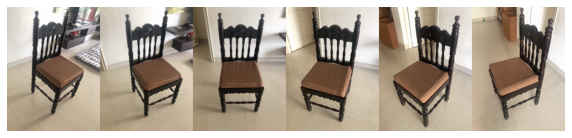

274 PNG files found


In [10]:
step = 50

plt.figure(figsize=(10,3))
plt.imshow(np.concatenate([image.imread(filename) for filename in sequence_filenames[::step]], axis=1))
plt.axis('off')
plt.show()
print(f'{len(sequence_filenames)} PNG files found')

## Preparing camera poses

Next, process Objectron's camera poses (captured through an AR session; see [ARKit](https://developer.apple.com/documentation/arkit/arcamera/2866108-transform) documentation)
and convert to the [LLFF](https://github.com/Fyusion/LLFF#using-your-own-poses-without-running-colmap) format accepted by JaxNeRF.

In [11]:
def make_poses_bounds_array(frame_data, near=0.2, far=10):
    # See https://github.com/Fyusion/LLFF#using-your-own-poses-without-running-colmap
    # Returns an array of shape (N, 17).
    rows = []
    for frame in frame_data:
        camera = frame.camera
        cam_to_world = np.array(camera.transform).reshape(4,4)[:3]
        w = camera.image_resolution_width
        h = camera.image_resolution_height
        assert w>=h, (w, h)  # assume landscape
        # JaxNeRF assumes x,y focal lengths are equal.
        row = llff_pose(cam_to_world, image_hw=[w, h],
                        focal=camera.intrinsics[0], near=near, far=far)
        rows.append(row)
    return np.vstack(rows)

def llff_pose(cam_to_world_mat34, image_hw, focal, near, far):
    # Returns an array of shape (17,).
    col = np.concatenate([image_hw, [focal]]).reshape(-1, 1)
    mat35 = np.hstack([cam_to_world_mat34, col])
    return np.concatenate([mat35.ravel(), [near, far]])

In [12]:
frame_data = load_frame_data(geometry_filename)
poses = make_poses_bounds_array(frame_data, near=0.2, far=10)

In [13]:
np.save('nerf_data/poses_bounds.npy', poses)

The data directory should now look like this:

In [14]:
ls -sh1 nerf_data/

total 23M
3.3M geometry.pbdata
 12K images_8/
 40K poses_bounds.npy
 20M video.MOV


In [15]:
def feature_points_from_frame_data(frames):
    # Returns an array of shape (N, 3).
    points = []
    for frame in frames:
        for v in frame.raw_feature_points.point:
            points.append([v.x, v.y, v.z])
    return np.array(points)

def draw_points(points):
    ax.scatter(points[:,0], points[:,1], points[:,2],
               marker='.', s=0.4)
    ax.set_box_aspect(np.ptp(points, axis=0))

def draw_camera(Rt, ax, scale):
    # Rt: 3x4 cam-to-world matrix
    R, t = Rt[:, :3].T, Rt[:,3]
    start_pts = np.tile(t, [3, 1])
    end_pts = scale * R + t
    lines = np.array([start_pts, end_pts]).transpose(1,0,2)
    colors=['red', 'blue', 'green']
    texts=['-y', 'x', 'z']
    ax.add_collection3d(
        art3d.Line3DCollection(lines, linewidths=1, colors=colors))
    for i, text in enumerate(texts):
        ax.text(lines[i,1,0], lines[i,1,1], lines[i,1,2],
                text, color='black')
    return ax

def draw_scene(ax, points, poses):
    dists = np.linalg.norm(points-points.mean(0), axis=1)
    # Get rid of outliers for visualization.
    points = points[dists<np.percentile(dists, 92)]
    draw_points(points)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    for i in range(0, len(poses)):
        # See llff_pose()
        Rt = poses[i, :-2].reshape([3, 5])[:,:4]
        draw_camera(Rt, ax=ax, scale=0.15)

We can visualize the camera axes. The LLFF format requires that the columns of the camera-to-world matrix correspond to [down, right, backwards, camera position] in world coordinates.

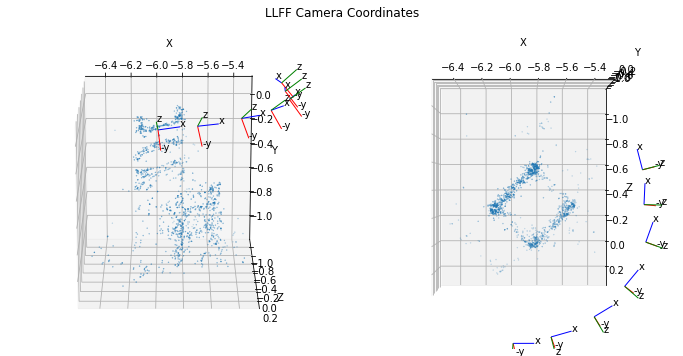

In [16]:
# There should be 274 image-camera pairs. Plot every 40th camera.
step = 40
# To make sure the cameras are oriented correctly, we also plot a point cloud of the object.
points = feature_points_from_frame_data(frame_data)

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
draw_scene(ax, points[::step], poses[::step])
ax.view_init(107, -90)

ax = fig.add_subplot(1, 2, 2, projection='3d')
draw_scene(ax, points[::step], poses[::step])
ax.view_init(180, -90)

fig.suptitle('LLFF Camera Coordinates')
plt.tight_layout()
plt.show()

## Training a NeRF model

Clone the JaxNeRF repo and follow the installation instructions: https://github.com/google-research/google-research/tree/master/jaxnerf

Save the configuration below as `configs/objectron_small.yaml` in the cloned `jaxnerf/` directory.

```yaml
dataset: llff
batching: all_images
num_coarse_samples: 64
num_fine_samples: 128
use_viewdirs: true
white_bkgd: false
batch_size: 256
randomized: true
near: 0.2
far: 10
factor: 8
llffhold: 8
noise_std: 1.
lr_init: 2.0e-3
lr_final: 2.0e-5
lr_delay_steps: 2500
lr_delay_mult: 0.1
max_steps: 250000
save_every: 5000
render_every: 5000
gc_every: 7500
spherify: True
lindisp: True
```

Then run the following command in a terminal to train NeRF. `--data_dir` corresponds to the `nerf_data` directory containing the RGB frames (in an `images_8` subdirectory) and camera poses (`poses_bounds.npy`).

```
python -m jaxnerf.train \
  --data_dir=./nerf_data \
  --train_dir=/PATH/TO/CHECKPOINTS \
  --config=configs/objectron_small
```

After training is finished (250k steps), we can evaluate on novel views. In the config file above, `llffhold: 8` means 1/8 of the images (every 8th) will be held out for testing.

```
python -m jaxnerf.eval \
  --data_dir=./nerf_data \
  --train_dir=/PATH/TO/CHECKPOINTS \
  --config=configs/objectron_small
  --chunk=4096
```

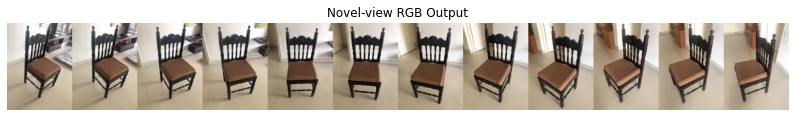

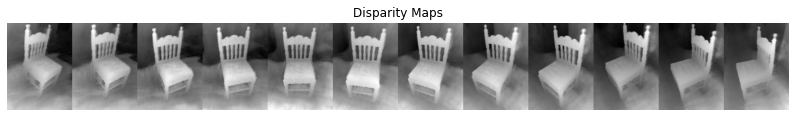

PSNR 29.48
SSIM 0.89


In [17]:
step = 3  # Visualize every 3th example.
checkpoint_dir = '/PATH/TO/CHECKPOINTS/'

output_filenames = sorted(glob.glob(path.join(checkpoint_dir, 'test_preds/*.png')))
plt.figure(figsize=(14,2))
plt.title('Novel-view RGB Output')
plt.imshow(np.concatenate([image.imread(filename) for filename in output_filenames[::step] if '/disp_' not in filename], axis=1))
plt.axis('off')

plt.figure(figsize=(14,2))
plt.title('Disparity Maps')
plt.imshow(np.concatenate([image.imread(filename) for filename in output_filenames[::step] if '/disp_' in filename], axis=1), cmap='gray')
plt.axis('off')
plt.show()

with open(path.join(checkpoint_dir, 'test_preds/psnr.txt'), 'r') as f:
    print('PSNR {:.2f}'.format(float(f.read())))
with open(path.join(checkpoint_dir, 'test_preds/ssim.txt'), 'r') as f:
    print('SSIM {:.2f}'.format(float(f.read())))